<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by Özlem Salehi</td>    
</table>
<hr>

# <font color="blue"> Solutions for </font> BQM for the Travelling Salesman Problem

### Imports

In [2]:
import itertools
from collections import defaultdict

import dimod
from dimod import BQM
import dwave_networkx as dnx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from neal import SimulatedAnnealingSampler
from dimod.reference.samplers import ExactSolver

from bqm_utils import graph_viz, tsp_viz

<a id="Task1"></a>


### Task 1

Find the optimal route for the given graph using simulated annealer and the built-in function.

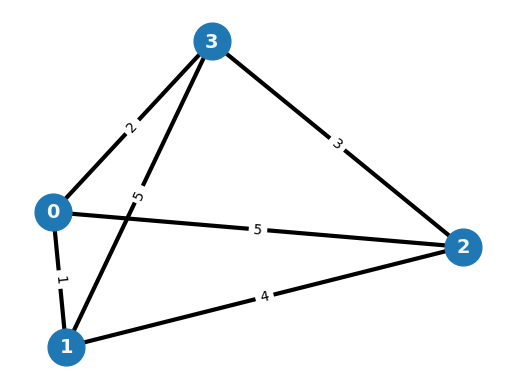

In [3]:
G = nx.Graph()
G.add_weighted_edges_from(
    {(0, 1, 1), (0, 2, 5), (0, 3, 2), (1, 2, 4), (1, 3, 5), (2, 3, 3)}
)
graph_viz(G)

### Solution

In [4]:
sampler = SimulatedAnnealingSampler()

path = dnx.traveling_salesperson(G, sampler, start=0)
print(path)

[0, 2, 3, 1]


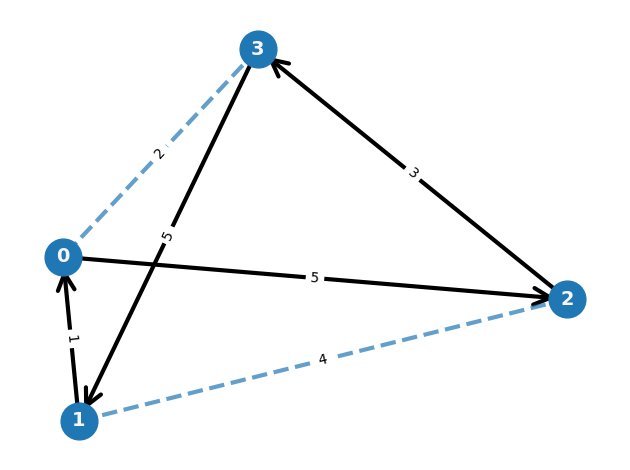

In [5]:
tsp_viz(G, path)

<a id="Task2"></a>

### Task 2

Add the second constraint to the BQM. Let langrange multiplier = 5.

### Solution

Let's define the graph as we have not defined it before.

In [8]:
G = nx.Graph()
G.add_weighted_edges_from(
    {(0, 1, 0.1), (0, 2, 0.5), (0, 3, 0.1), (1, 2, 0.1), (1, 3, 0.5), (2, 3, 0.1)}
)

Let's define the objective function and add the first constraint for completeness.

In [7]:
bqm = BQM("BINARY")

N = len(G.nodes)
for i in range(N):
    for j in range(i + 1, N):
        for t in range(N - 1):
            bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t+1}", G[i][j]["weight"])

        # Remember that we were assuming N=0 in the sum
        bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", G[i][j]["weight"])
l1 = 5
for t in range(N):
    c1 = [(f"x_{i}_{t}", 1) for i in range(N)]  # coefficient list
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=l1)

Now here comes the actual solution to the Task. 

In [9]:
l2 = 5
for i in range(N):
    c2 = [(f"x_{i}_{t}", 1) for t in range(N)]
    bqm.add_linear_equality_constraint(c2, constant=-1, lagrange_multiplier=l2)

<a id="Task3"></a>


### Task 3

Write a Python function named `is_sample_feasible` that takes as parameter a sample containing binary variables named `x_i_p` and their values and the number of cities, and returns True if the sample corresponds to a feasible path and false otherwise.

### Solution

In [10]:
def is_sample_feasible(sample, N):
    for i in range(N):
        if sum(sample[f"x_{i}_{t}"] for t in range(N)) != 1:
            return False
    for t in range(N):
        if sum(sample[f"x_{i}_{t}"] for i in range(N)) != 1:
            return False
    return True

<a id="Task4"></a>

### Task 4

Write a Python function named `sample_to_path` that takes as parameter a sample containing binary variables named `x_i_p` and their values and the number of cities, and returns a list of cities corresponding to the sample. 

### Solution

In [11]:
def sample_to_path(sample, N):
    path = []
    for t in range(N):
        for i in range(N):
            if sample[f"x_{i}_{t}"] == 1:
                path.append(i)
    return path

<a id="Task5"></a>

### Task 5

Write a function named `tsp_bqm` that takes as parameter a networkx graph G and the penalty coefficient and returns the binary quadratic model for the travelling salesmen problem.

### Solution

In [12]:
def tsp_bqm(G, P):

    N = len(G.nodes)
    bqm = BQM("BINARY")
    for i in range(N):
        for j in range(N):
            if i != j:
                for t in range(N - 1):
                    bqm.add_quadratic(f"x_{i}_{t}", f"x_{j}_{t+1}", G[i][j]["weight"])

                # Remember that we were assuming N=0 in the sum
                bqm.add_quadratic(f"x_{i}_{N-1}", f"x_{j}_{0}", G[i][j]["weight"])
    # Add the first constraint
    for t in range(N):
        c1 = [(f"x_{i}_{t}", 1) for i in range(N)]  # coefficient list
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=P)
    # Add the second constraint
    for i in range(N):
        c2 = [(f"x_{i}_{t}", 1) for t in range(N)]
        bqm.add_linear_equality_constraint(c2, constant=-1, lagrange_multiplier=P)
    return bqm

### Task 6

For the graph `G1` defined above, construct the bqm and find the optimal path.

Don't forget to set the penalty coefficient to a suitable value.

### Solution

In [13]:
np.random.seed(45)
G1 = nx.complete_graph(6)
for u, v in G1.edges():
    G1[u][v]["weight"] = np.random.randint(1, 5)
N = len(G1.nodes)

We should set the penalty coefficient to a value larger than 4 as this is the largest number appearing in the edge cost.

In [14]:
bqm = tsp_bqm(G1, 5)

In [15]:
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=1000)

In [16]:
first_sample = sampleset.first.sample
is_sample_feasible(first_sample,N)

True

In [17]:
path = sample_to_path(first_sample,N)
print(path)

[1, 4, 0, 5, 2, 3]


In [18]:
sampleset.first.energy

8.0

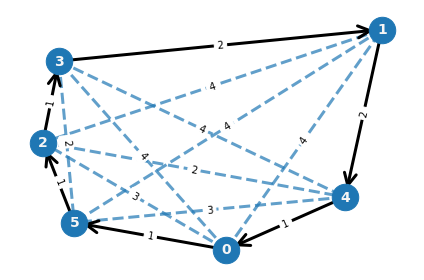

In [19]:
tsp_viz(G1, path)